# AUTOENCODER - CIFAR10

## importing needed libraries

In [173]:
import os
import torch
import torchvision
# import tarfile
# from torchvision.datasets.utils import download_url
# from torch.utils.data import random_split
# from PIL import Image
import numpy as np 
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
# from tqdm import tqdm
# from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import time
from datetime import datetime


## loading data

In [174]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.485, 0.456, 0.406))])

train_batch_size = 2000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,
                                          shuffle=True, num_workers=2)
test_batch_size = 2000
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Files already downloaded and verified
Files already downloaded and verified


In [175]:
train_images, train_labels = next(iter(trainloader))
print(train_images)

tensor([[[[ 0.2856,  0.3988,  0.4150,  ...,  0.2290,  0.2452,  0.3018],
          [ 0.2452,  0.3422,  0.4716,  ...,  0.0269,  0.0511,  0.0350],
          [ 0.1077,  0.1643,  0.3099,  ..., -0.2399, -0.2642, -0.2885],
          ...,
          [-0.1833, -0.2238, -0.2076,  ...,  0.0350,  0.5605,  0.5201],
          [-0.3370, -0.3370, -0.3451,  ..., -0.2076,  0.2695,  0.3422],
          [-0.3774, -0.3693, -0.3612,  ..., -0.3046, -0.1106,  0.0026]],

         [[ 0.3674,  0.4448,  0.4276,  ...,  0.3158,  0.3244,  0.3760],
          [ 0.2384,  0.3158,  0.4190,  ...,  0.1008,  0.1352,  0.1180],
          [ 0.1610,  0.2126,  0.3588,  ..., -0.0798, -0.0884, -0.1056],
          ...,
          [ 0.1094,  0.1094,  0.1610,  ...,  0.3072,  0.7458,  0.7286],
          [ 0.1180,  0.1352,  0.1180,  ...,  0.1180,  0.4878,  0.5222],
          [ 0.1782,  0.1696,  0.1610,  ...,  0.1008,  0.1868,  0.2126]],

         [[ 0.6903,  0.7290,  0.7773,  ...,  0.4972,  0.4682,  0.5261],
          [ 0.5454,  0.5937,  

In [176]:
test_images, test_labels = next(iter(testloader))
print(test_images)


tensor([[[[ 0.2775,  0.2856,  0.3341,  ...,  0.1077,  0.0188, -0.0621],
          [ 0.2290,  0.2209,  0.2856,  ...,  0.0997,  0.0107, -0.0378],
          [ 0.2209,  0.2209,  0.2775,  ...,  0.1239,  0.0511, -0.0297],
          ...,
          [-0.4502, -0.6604, -0.7493,  ..., -0.6927, -0.8949, -0.6766],
          [-0.5068, -0.6038, -0.7170,  ..., -0.7898, -0.7655, -0.8383],
          [-0.5634, -0.5472, -0.6361,  ..., -0.8059, -0.7251, -0.8302]],

         [[-0.0368, -0.0454, -0.0024,  ..., -0.1830, -0.2174, -0.2690],
          [-0.0368, -0.0540, -0.0196,  ..., -0.1830, -0.2174, -0.2432],
          [-0.0540, -0.0626, -0.0454,  ..., -0.1572, -0.1830, -0.2346],
          ...,
          [ 0.0664, -0.1400, -0.2432,  ..., -0.1658, -0.4496, -0.2690],
          [-0.0024, -0.1228, -0.2690,  ..., -0.2948, -0.2948, -0.4496],
          [-0.0798, -0.0970, -0.2346,  ..., -0.3378, -0.2776, -0.4238]],

         [[-0.5267, -0.5460, -0.5074,  ..., -0.6523, -0.6523, -0.6813],
          [-0.5074, -0.6136, -

In [177]:
print(train_images.size())
print(test_images.size())

torch.Size([2000, 3, 32, 32])
torch.Size([2000, 3, 32, 32])


In [178]:
print(train_images[0:1].shape)
subtrain1 = train_images[500:1000] 
subtrain2 = train_images[1000:1500]
print(subtrain1.size())

torch.Size([1, 3, 32, 32])
torch.Size([500, 3, 32, 32])


## generating our specific data

In [179]:
labels1 = []
labels2 = []
avg_input = []
for i in range(300):
    for j in range(i,300):
        labels1.append(subtrain1[i])
        labels2.append(subtrain2[j])
        avg_input.append((subtrain1[i]+subtrain2[j])/2)

In [180]:
for i in range(len(avg_input)):
    avg_input[i] = np.transpose(avg_input[i],[2, 1, 0])

for j in range(len(labels1)):
    labels1[j] = np.transpose(labels1[j],[2, 1, 0])
    labels2[j] = np.transpose(labels2[j],[2, 1, 0])

print(len(avg_input))
type(avg_input)


45150


list

## giving some examples of generated data

tensor([[[ 0.0188, -0.0110, -0.1790],
         [-0.0297, -0.0626, -0.2466],
         [-0.0216, -0.0454, -0.2273],
         ...,
         [-0.4906, -0.5270, -0.5653],
         [-0.4421, -0.4582, -0.5364],
         [-0.3774, -0.3894, -0.4591]],

        [[ 0.0511, -0.0110, -0.1693],
         [ 0.0431, -0.0196, -0.1790],
         [ 0.0511, -0.0110, -0.1693],
         ...,
         [-0.4663, -0.5442, -0.5653],
         [-0.4017, -0.4496, -0.4881],
         [-0.3774, -0.4066, -0.4301]],

        [[ 0.1077,  0.0406, -0.1017],
         [ 0.0350, -0.0368, -0.1983],
         [ 0.0673, -0.0024, -0.1597],
         ...,
         [-0.4583, -0.5356, -0.5653],
         [-0.4097, -0.4754, -0.5267],
         [-0.4178, -0.4496, -0.5460]],

        ...,

        [[ 0.0350,  0.0320, -0.1790],
         [ 0.0026, -0.0024, -0.2273],
         [ 0.0107,  0.0062, -0.2176],
         ...,
         [ 0.0188, -0.3550, -0.4398],
         [-0.0378, -0.3120, -0.4108],
         [-0.1187, -0.3636, -0.4205]],

        [[

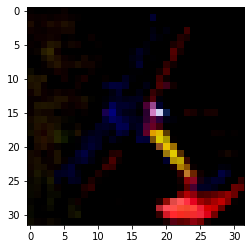

In [181]:
print(labels1[10])
plt.imshow(labels1[10])
plt.show()


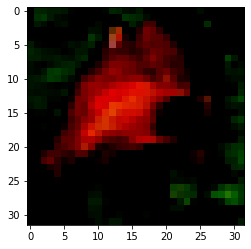

In [182]:
plt.imshow(labels2[10])
plt.show()

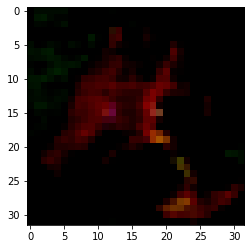

In [183]:
plt.imshow(avg_input[10])
plt.show()

In [184]:
avg_input = np.array(avg_input)
labels1 = np.array(labels1)
labels2 = np.array(labels2)
print(labels1[0].shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_lau

torch.Size([32, 32, 3])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing im

## creating the model

In [185]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
#             nn.MaxPool2d((2, 2)),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),            
            nn.ReLU(),
#             nn.MaxPool2d((2, 2)),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),           
            nn.ReLU(),
#             nn.MaxPool2d((2, 2)),
            nn.Conv2d(48, 96, 4, stride=2, padding=1),           
            nn.ReLU(),
        )

        self.decoder1 = torch.nn.Sequential(
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),
#             nn.Conv2d(96, 48, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
#             nn.Conv2d(48, 24, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
#             nn.Conv2d(24, 12, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
#             nn.Conv2d(12, 6, 4, stride=2, padding=1),         
            nn.Sigmoid(),
        )

        self.decoder2 = torch.nn.Sequential(
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),
#             nn.Conv2d(96, 48, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
#             nn.Conv2d(48, 24, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
#             nn.Conv2d(24, 12, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
#             nn.Conv2d(12, 6, 4, stride=2, padding=1),         
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded1 = self.decoder1(encoded)
        decoded2 = self.decoder2(encoded)
        return decoded1, decoded2

In [186]:
def create_model():
    autoencoder = Autoencoder()
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
    return autoencoder

In [187]:
SEED = 87
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [188]:
model = create_model()
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (decoder1): Sequential(
    (0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
  (decoder2): Sequential(
    (0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(48, 24, kern

### training the model

In [189]:
epochs = 15
losses = []
for epoch in range(epochs):
    t0 = datetime.now()
    running_loss = 0.0    
    for i in range(50):
        tar1 = train_images[i:i+1]
        tar1 = tar1.cuda()
        for j in range(600,650):
            tar2 = train_images[j:j+1] 
            inp = torch.FloatTensor([((tar1.cpu()[0].numpy()+tar2.cpu()[0].numpy())/2).tolist()])
            inp = inp.cuda()
            tar2 = tar2.cuda()
            

            out1, out2 = model(inp)
            loss_1 = criterion(out1, tar1)
            loss_2 = criterion(out2, tar2)
            loss = loss_1 + loss_2
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.data
    losses.append(running_loss/2500)
    
    dt = datetime.now() - t0
    print(f'Running epoch {epoch+1} out of {epochs},Train_Loss: {losses[-1]:.4f}, Duration: {dt} ')


Running epoch 1 out of 15,Train_Loss: 0.5211, Duration: 0:00:14.237185 
Running epoch 2 out of 15,Train_Loss: 0.4871, Duration: 0:00:13.943799 
Running epoch 3 out of 15,Train_Loss: 0.4274, Duration: 0:00:13.788011 
Running epoch 4 out of 15,Train_Loss: 0.3916, Duration: 0:00:14.206366 
Running epoch 5 out of 15,Train_Loss: 0.3716, Duration: 0:00:13.797600 
Running epoch 6 out of 15,Train_Loss: 0.3546, Duration: 0:00:14.720467 
Running epoch 7 out of 15,Train_Loss: 0.3418, Duration: 0:00:13.721105 
Running epoch 8 out of 15,Train_Loss: 0.3314, Duration: 0:00:14.208391 
Running epoch 9 out of 15,Train_Loss: 0.3236, Duration: 0:00:13.671465 
Running epoch 10 out of 15,Train_Loss: 0.3173, Duration: 0:00:14.571257 
Running epoch 11 out of 15,Train_Loss: 0.3119, Duration: 0:00:13.675025 
Running epoch 12 out of 15,Train_Loss: 0.3081, Duration: 0:00:13.888413 
Running epoch 13 out of 15,Train_Loss: 0.3046, Duration: 0:00:14.375141 
Running epoch 14 out of 15,Train_Loss: 0.3022, Duration: 0:0

### ploting train losses

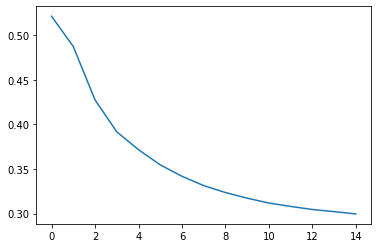

In [190]:
plot_losses = []
for l in losses:
    plot_losses.append(float(l.cpu()))
          
plt.plot(plot_losses)
plt.show()

## testing the model and its visualization

In [210]:
test_losses = []
total_loss = 0.0

for i in range(100):
    Tinp1 = test_images[i:i+1]
    Tinp1 = Tinp1.cuda()
    for j in range(100,200):
        Tinp2 = test_images[j:j+1]
        Tinp2 = Tinp2.cuda()
        test_inp = torch.FloatTensor([((Tinp1.cpu()[0].numpy()+Tinp2.cpu()[0].numpy())/2).tolist()])
        test_inp = test_inp.cuda()
        test_out1, test_out2 = model(test_inp)
        
        test_loss_1 = criterion(test_out1, Tinp1)
        test_loss_2 = criterion(test_out2, Tinp2)
        test_loss = test_loss_1 + test_loss_2
        running_loss += test_loss.data
test_losses.append(running_loss/10000)


        
inp1 = test_images[10:11]
inp2 = test_images[19:20]

test_input = torch.FloatTensor([((inp1.cpu()[0].numpy()+inp2.cpu()[0].numpy())/2).tolist()])
test_input = test_input.cuda()

test_output1, test_output2 = model(test_input)
test_loss_1 = criterion(test_out1, Tinp1)
test_loss_2 = criterion(test_out2, Tinp2)
test_loss = test_loss_1 + test_loss_2
print(test_loss)


tensor(0.5274, device='cuda:0', grad_fn=<AddBackward0>)


In [211]:
print(test_losses)

[tensor(0.0189, device='cuda:0')]


real image - input 1
it is a  tensor([0])


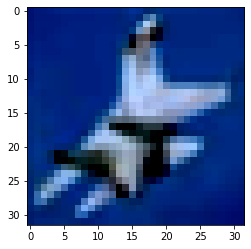

In [202]:
print("real image - input 1")
print("it is a ", str(test_labels[10:11]))
inp1 = np.transpose(inp1[0],[2, 1, 0])
plt.imshow(torchvision.utils.make_grid(inp1.data))

real image - input 2
it is a  tensor([9])


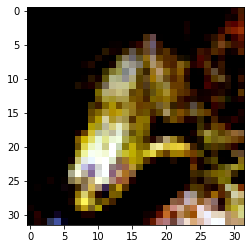

In [203]:
print("real image - input 2")
print("it is a ", str(test_labels[11:12]))
inp2 = np.transpose(inp2[0],[2, 1, 0])
plt.imshow(torchvision.utils.make_grid(inp2.data))

avarage image - input


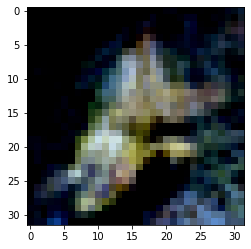

In [206]:
print("avarage image - input")

avg = torch.FloatTensor([((inp2.cpu().numpy()+inp1.cpu().numpy())/2).tolist()])
avg = np.array(avg)
plt.imshow(avg[0])

predected image - output 1


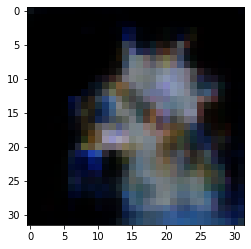

In [207]:
print("predected image - output 1")

index = test_output1[0].cpu()
index = index.detach().numpy()
test_output1 = np.transpose(index,[2, 1, 0])
plt.imshow(test_output1)

predected image - output 1


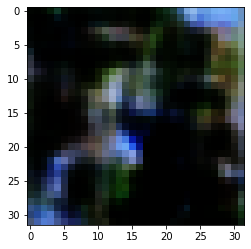

In [208]:
print("predected image - output 1")

type(test_output2[0])
index = test_output2[0].cpu()
index = index.detach().numpy()
# output1 = np.array(index)
type(index)
index.shape
test_output2 = np.transpose(index,[2, 1, 0])
plt.imshow(test_output2)